This tutorial shows you how to use our toolkit to solve 2d labelfree task.

In [1]:
#first check whether you have gpu resources.
import torch
torch.cuda.is_available()

True

In [ ]:
#@title 1. Install the mmv_im2im package
# this should be discarded later once pr is merged.
!git clone https://github.com/MMV-Lab/mmv_im2im.git
%cd mmv_im2im
!git checkout plt2.0
!pip install -q -e .[all]
%cd ..

In [10]:
#@title 2.Mount to your own google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
#@title 3.Download the dataset from zenodo
import pooch
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
from random import random
import numpy as np


data_path = Path("/content/gdrive/MyDrive/data/labelfree2D")
p = data_path / Path("download")
p.mkdir(exist_ok=True, parents=True)
p = data_path / Path("train")
p.mkdir(exist_ok=True,parents=True)
p = data_path / Path("test")
p.mkdir(exist_ok=True,parents=True)
p = data_path / Path("pred")
p.mkdir(exist_ok=True,parents=True)

source_part1 = pooch.retrieve(
    url="doi:10.5281/zenodo.6139958/20210904_TL2 - R05-C03-F0.tif",
    known_hash="md5:1d6cb5b86f39f9accb6ee53367bda8e1",
    fname="20210904_TL2-R05-C03-F0.tiff",
    path=data_path / Path("download")
)

reader = AICSImage(source_part1)

# input (bright field) channel: 2
# ground truth (mCherry-H2B) channel: 4
fn_base = Path(source_part1).stem
for tt in range(reader.dims.T):
    im = reader.get_image_data("YX", Z=0, T=tt, C=2)
    gt = reader.get_image_data("YX", Z=0, T=tt, C=4)
    if random() < 0.15:
        data_type = "test"
    else:
        data_type = "train"

    out_fn = data_path / f"{data_type}" / f"{fn_base}_{tt:03d}_IM.tiff"
    OmeTiffWriter.save(im.astype(np.uint16), out_fn, dim_order="YX")

    out_fn = data_path / f"{data_type}" / f"{fn_base}_{tt:03d}_GT.tiff"
    OmeTiffWriter.save(gt.astype(np.uint16), out_fn, dim_order="YX")

source_part2 = pooch.retrieve(
    url="doi:10.5281/zenodo.6140064/training_dataset.zip",
    known_hash="md5:7d218466d217fd62dc8ec56ad76d23d7",
    fname="labelfree2d_part2.zip",
    path=data_path / Path("download")
)
with zipfile.ZipFile(source_part2,"r") as zip_ref:
    zip_ref.extractall(data_path / Path("download"))

for source_set in ["train", "test"]:
    source_path = data_path / Path("download") / f"{source_set}"
    filenames = sorted(source_path.glob("*_bf.tif"))
    for fn in filenames:
        fn_fluo = source_path / f"{fn.stem[:-2]}fluo.tif"
        fn_base = fn.stem.replace(" ", "")

        # get bright field image
        bf_reader = AICSImage(fn)
        im = bf_reader.get_image_data("YX", Z=0, T=0, C=0)

        # get H2b fluorescent image
        h2b_reader = AICSImage(fn_fluo)
        gt = h2b_reader.get_image_data("YX", Z=0, C=1, T=0)

        if random() < 0.15:
            data_type = "test"
        else:
            data_type = "train"

        out_fn = data_path / f"{data_type}" / f"{fn_base}_IM.tiff"
        OmeTiffWriter.save(im.astype(np.uint16), out_fn, dim_order="YX")

        out_fn = data_path / f"{data_type}" / f"{fn_base}_GT.tiff"
        OmeTiffWriter.save(gt.astype(np.uint16), out_fn, dim_order="YX")

# you may remove the download folder now.
from shutil import rmtree
rmtree(data_path / Path("download"))

Show how the image looks like:

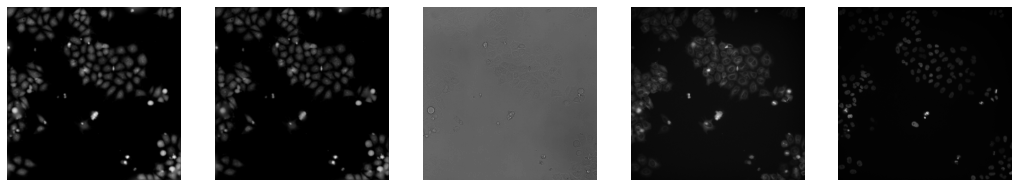

In [29]:
sample = reader.get_image_data("CYX", T=100, Z=0)
fig, ax = plt.subplots(1, reader.dims.C, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
for channel in range(reader.dims.C):
    ax[channel].axis('off')
    ax[channel].imshow(sample[channel,:,:], cmap=plt.cm.gray)

### 4. Run the model

We can run our package by using `run_im2im` command from CLI

- for training:

In [ ]:
!run_im2im --config '/content/mmv_im2im/paper_configs/labelfree_2d_FCN_train.yaml'\
      --data.data_path '/content/gdrive/MyDrive/data/labelfree2D/train'\
      --trainer.params "{'max_epochs':2}"\
      --trainer.callbacks "[]"\
      --data.dataloader.train.dataloader_params "{'batch_size':1,'num_workers':1}"


  - for testing:





In [ ]:
!run_im2im --config '/content/mmv_im2im/paper_configs/labelfree_2d_FCN_inference.yaml'\
      --data.inference_input.dir '/content/gdrive/MyDrive/data/labelfree2D/test'\
      --data.inference_output.path '/content/gdrive/MyDrive/data/labelfree2D/pred'\
      --model.checkpoint '/content/lightning_logs/version_0/checkpoints/best.ckpt'